In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [3]:
# Reading the texts 
def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions



In [4]:
captions = readTextFile("./flickr_data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split("\n")[:-1]

In [5]:
import cv2

In [6]:
#Dictionary to map each Image with the list of captions it has

In [7]:
descriptions = {}
for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not 
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)
    

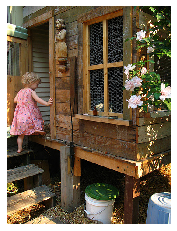

In [8]:
IMG_PATH = "./flickr_data/Flickr_Data/Images/"


img = cv2.imread(IMG_PATH+"1000268201_693b08cb0e.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")

plt.show()





In [9]:
# Data Cleaning

In [10]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

In [11]:
clean_text("A cat is sittnig over the house number # 64")

'cat is sittnig over the house number'

In [12]:
# clean all captions 
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [13]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [14]:
# Wrting data to a text file 
with open("descriptions_1.txt","w") as f:
    f.write(str(descriptions))
    

In [15]:
# Vocabulary

In [16]:
descriptions = None
with open("descriptions_1.txt","r") as f:
    descriptions = f.read()

json_acceptable_string = descriptions.replace("'","\"")
    
descriptions = json.loads(json_acceptable_string)

In [17]:
print(type(descriptions))

<class 'dict'>


In [18]:
descriptions["1000268201_693b08cb0e"]

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [19]:
# Vocab

vocab = set()
for key in descriptions.keys():
    [ vocab.update(sentence.split()) for sentence in descriptions[key]]
    
print("Vocab Size : %d"%len(vocab))

Vocab Size : 8424


In [20]:
# Total no of words across all the sentences
total_words = []
for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]

print("Total Words :%d"%len(total_words))

Total Words :373837


In [21]:
# Filter words from vocab according to certain threshold frequency

In [22]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt))

8424


In [23]:
 # Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_cnt.items(),reverse = True,key=lambda x:x[1])
   
    
#Filter
threshold = 10
sorted_freq_cnt = [x for x in sorted_freq_cnt if x[1] > threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [24]:
# Prepeare Train/Test data

In [25]:
train_file_data = readTextFile("flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("flickr_data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [26]:
train = [row.split(".")[0] for row in train_file_data.split("\n")][:-1]
#print(train[:5])
test = [row.split(".")[0] for row in test_file_data.split("\n")][:-1]
train = [row.split(".")[0] for row in train_file_data.split("\n")][:-1]
#print(train[:10])



In [27]:
# Prepare Description for the traingin Data
# Adding <s> and <e> token to our training data

train_descriptions = {}
for img_id in train:
    train_descriptions[img_id] = []
    for cap in descriptions[img_id]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[img_id].append(cap_to_append)

In [28]:
train_descriptions["1000268201_693b08cb0e"]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [29]:
# Transfer Learning
# Images --> Feature
# text --> Feature

In [30]:
# Image Feature Extraction 
# We are using a pre trained model Resnet50

In [31]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [32]:
model_new = Model(model.input,model.layers[-2].output)

In [33]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    #Normalisation
    img = preprocess_input(img)
    return img
    

In [34]:
#img = preprocess_img(IMG_PATH+  "1000268201_693b08cb0e.jpg")
#plt.imshow(img[0])
#plt.show()

In [35]:
def encode_img(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [36]:
encode_img(IMG_PATH + "1000268201_693b08cb0e.jpg")

array([0.041543  , 0.17076081, 0.292786  , ..., 0.05089618, 0.3132235 ,
       0.8600756 ], dtype=float32)

In [41]:
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_train[img_id] = encode_img(img_path)
    
    if(ix%100 == 0):
        print("Encoding in progress Time Step %d"%ix)
        
end_t = time()
print("Total Time taken : %d"%(end_t - start) )    

Encoding in progress Time Step 0
Encoding in progress Time Step 100
Encoding in progress Time Step 200
Encoding in progress Time Step 300
Encoding in progress Time Step 400
Encoding in progress Time Step 500
Encoding in progress Time Step 600
Encoding in progress Time Step 700
Encoding in progress Time Step 800
Encoding in progress Time Step 900
Encoding in progress Time Step 1000
Encoding in progress Time Step 1100
Encoding in progress Time Step 1200
Encoding in progress Time Step 1300
Encoding in progress Time Step 1400
Encoding in progress Time Step 1500
Encoding in progress Time Step 1600
Encoding in progress Time Step 1700
Encoding in progress Time Step 1800
Encoding in progress Time Step 1900
Encoding in progress Time Step 2000
Encoding in progress Time Step 2100
Encoding in progress Time Step 2200
Encoding in progress Time Step 2300
Encoding in progress Time Step 2400
Encoding in progress Time Step 2500
Encoding in progress Time Step 2600
Encoding in progress Time Step 2700
Enco

In [42]:
# Store everything to disk


with open("encoded_train_feature.pk1","wb") as f:
    pickle.dump(encoding_train,f)

In [43]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH + "/" + img_id + ".jpg"
    encoding_test[img_id] = encode_img(img_path)
    
    if(ix%100 == 0):
        print(" Test Encoding in progress Time Step %d"%ix)
        
end_t = time()
print("Total Time taken : %d"%(end_t - start) )    

 Test Encoding in progress Time Step 0
 Test Encoding in progress Time Step 100
 Test Encoding in progress Time Step 200
 Test Encoding in progress Time Step 300
 Test Encoding in progress Time Step 400
 Test Encoding in progress Time Step 500
 Test Encoding in progress Time Step 600
 Test Encoding in progress Time Step 700
 Test Encoding in progress Time Step 800
 Test Encoding in progress Time Step 900
Total Time taken : 201


In [44]:

with open("encoded_test_feature.pk1","wb") as f:
    pickle.dump(encoding_test,f)

In [45]:
#Data pre-processing for captions

In [46]:
#Vocab
len(total_words)

1845

In [47]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word
    

In [48]:
idx_to_word[1]

'in'

In [49]:
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) +1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [50]:
max_len = 0
for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        max_len = max(max_len,len(cap.split()))
print(max_len)

35


In [51]:
# Data Generator


In [53]:
def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    
    X1,X2,y = [],[],[]
    
    n=0
    while true:
        for key ,desc_list in train_descriptions.items():
            h += 1
            
            photo = encoding_train[key+".jpg"]
            
            for desc in desc_list:
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
            
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
            
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    
                    yi = to_categorical([yi],num_classes = vocab_size[0])
                    
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n == batch_size:
                    
                    yield[[np.array(X1),np.array(X2),np.array(y)]]
                    
                    X1,X2,y = [],[],[]
                    n = 0
                    
                   
            
            
            
            

In [54]:
# Word Embedding


In [56]:
f = open("./glove.6B.50d.txt",encoding = 'utf-8')

In [57]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    word_embedding  = np.array(values[1:],dtype ='float')
    embedding_index[word] = word_embedding

In [59]:
f.close()

In [60]:
embedding_index['apple']

array([ 0.52042 , -0.8314  ,  0.49961 ,  1.2893  ,  0.1151  ,  0.057521,
       -1.3753  , -0.97313 ,  0.18346 ,  0.47672 , -0.15112 ,  0.35532 ,
        0.25912 , -0.77857 ,  0.52181 ,  0.47695 , -1.4251  ,  0.858   ,
        0.59821 , -1.0903  ,  0.33574 , -0.60891 ,  0.41742 ,  0.21569 ,
       -0.07417 , -0.5822  , -0.4502  ,  0.17253 ,  0.16448 , -0.38413 ,
        2.3283  , -0.66682 , -0.58181 ,  0.74389 ,  0.095015, -0.47865 ,
       -0.84591 ,  0.38704 ,  0.23693 , -1.5523  ,  0.64802 , -0.16521 ,
       -1.4719  , -0.16224 ,  0.79857 ,  0.97391 ,  0.40027 , -0.21912 ,
       -0.30938 ,  0.26581 ])

In [64]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if(embedding_vector) is not None:
            matrix[idx] = embedding_vector
            
    return matrix

In [65]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(1848, 50)

In [67]:
# model Architecture

In [93]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [95]:
# Captions as Input
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=50,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [74]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [75]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 35, 50)       92400       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [96]:
# Important - Embedding Layer

model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [97]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [84]:
epochs = 20
batch_size = 3
steps = len(train_descriptions)#number_pics_per_batch


In [86]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [98]:
model = load_model('./model_weights/model_9.h5')

In [99]:
# Predictions

In [100]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

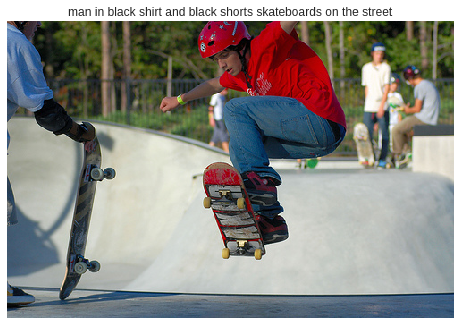

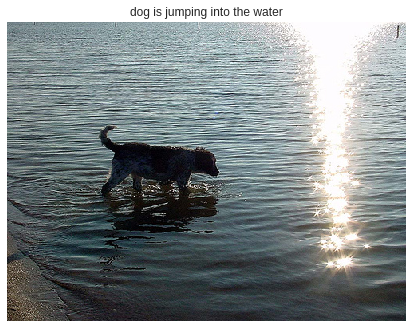

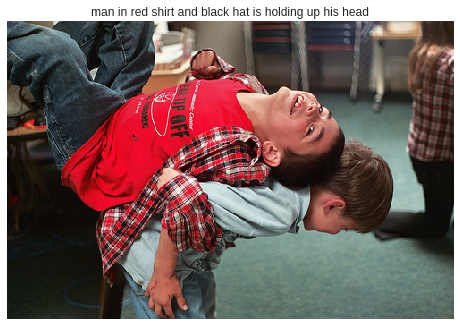

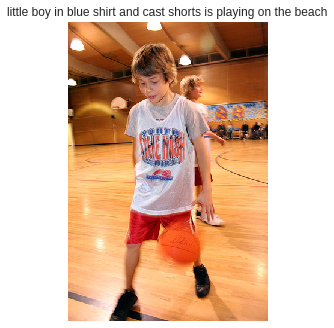

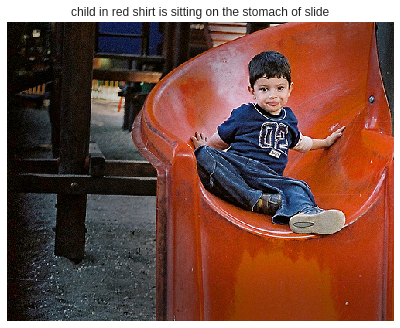

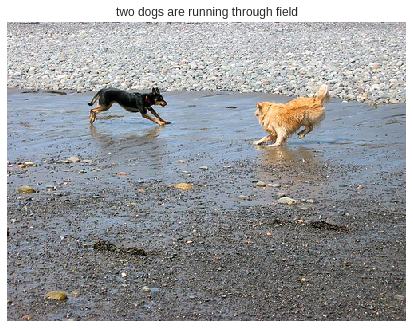

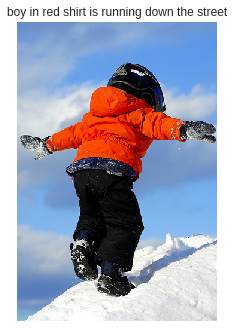

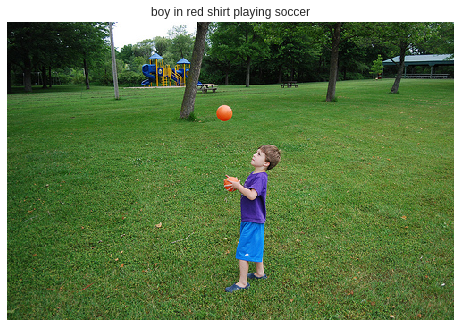

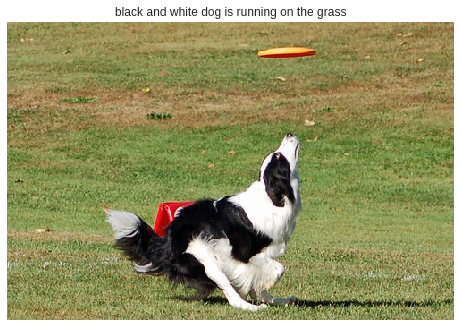

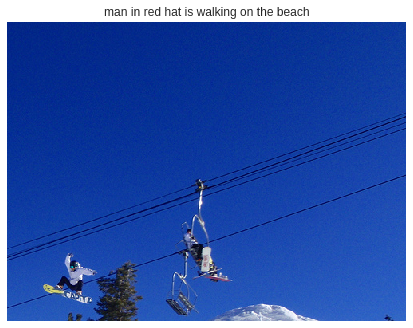

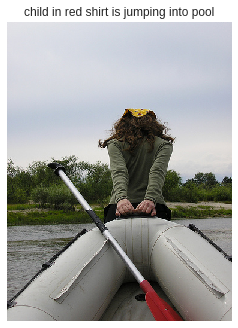

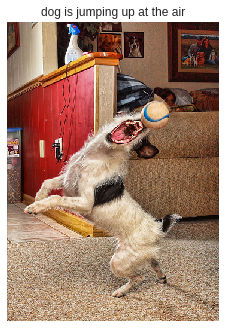

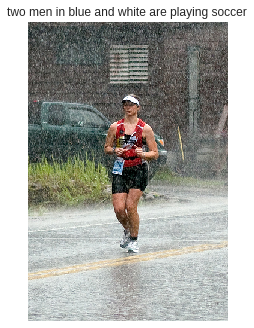

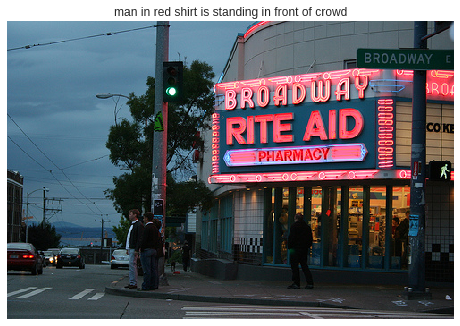

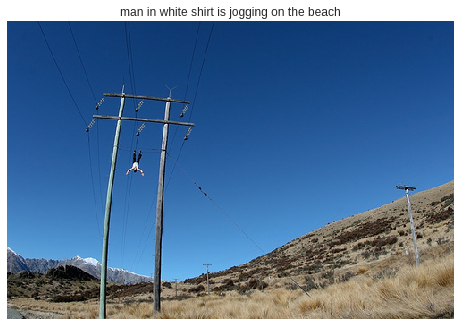

In [107]:
# Pick Some Random Images and See Results
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./flickr_data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()
    